# 🧪 Clinical trial project (1) - Raquel G Vernet 

Hi! 👋 This notebook is part of my personal data science portfolio.

The goal of this project is to simulate a clinical study and then analyze the data to determine whether the treatment was effective. 

**❗ Important!** *This is a fictional dataset created for portfolio purposes. The narrative serves only as a creative introduction; the subsequent analysis follows a scientific approach*

In this notebook, you will find:

0. **Fictional background** – Context and rationale for the study.
1. **Experimental Design** – Description of the double-blind Randomized Controlled Trial (RCT), variables collected, and statistical power calculation (considering 175 patients per group and α = 0.05).
2. **Database Simulation** – Generation of the dataset and visualization with a final CONSORT diagram.
3. **Exploratory Data Analysis (EDA)** – Summary tables, histograms, boxplots, and stacked barplots to explore the data.
4. **Treatment Efficacy and Outcome Analysis** – Kaplan–Meier curves, Log-rank tests, ANOVA with post-hoc tests, and Chi-square tests to assess statistical significance and support conclusions.
5. **Conclusions**

### 0. Fictional background

**Year 8 P.I. (Post Impact).** A strange disease has been detected in the areas surrounding the crater, and panic is starting to spread. The symptoms are aggressive and appear suddenly, often leading to death. Time is of the essence, and while efforts focus on developing a vaccine, we are tasked with finding treatments that could save patients’ lives.

Upon arriving at the centers in the affected zone, we receive the following information:

- The illness is caused by a virus (ALIEN-1), previously unknown. The mode of transmission is unclear, but it does not appear to be airborne.

- A blood sample can be taken to detect the virus through PCR testing, although generally occurs after the first symptoms. Inflammatory markers are also altered and may serve as prognostic indicators.

- Symptoms last between 1 and 6 days before reaching the final stage. They include headaches, hallucinations, hydrophobia, hysteria, high fever, and increased aggression. After this period, a large percentage of patients fall into a coma and die; the rest may recover, though with varying degrees of long-term sequelae. 

- Interestingly, a small percentage of patients (about 5–10%) experience unexpectedly beneficial response to the infection, showing a better clinical status than at baseline.

After reviewing all this information, we decided to try a new antiviral, ANT-18, administered in the early and late stages of the disease to assess its effectiveness in improving survival and reducing long-term complications. 

## 1. Experimental design

We will conduct a **double-blind Randomized Controlled Trial (RCT)** including 700 patients (originally healthy, aged 20–60). Participants will be **randomly assigned and stratified by age and sex** to ensure balanced distribution across the following groups:

- Early Treat (EarlyT): ANT-18 administered on the first day after symptom onset.
- Early Placebo (EarlyP): Placebo administered on the first day after symptom onset.
- Late Treat (LateT): ANT-18 administered on the fourth day after symptom onset.
- Late Placebo (LateP): Placebo administered on the fourth day after symptom onset.

| Variable                  | Type        | Units            | Notes                                                                 |
|---------------------------|-------------|------------------|----------------------------------------------------------------------|
| Age                       | Continuous  | Years            | Baseline demographic                                                 |
| Sex                       | Categorical | Male/Female      | Baseline demographic                                                 |
| ALIEN-1 PCR               | Binary      | Positive/Negative| Pre-treatment diagnostic                                             |
| Inflammatory markers pre  | Continuous  | mg/L             | Pre-treatment measure                                                |
| Time to recovery          | Continuous  | Days             | From symptom onset                                                   |
| Time to death             | Continuous  | Days             | From symptom onset                                                   |
| Week 8 outcome            | Binary      | 0/1              | 0 = death, 1 = survived                                              |
| Week 8 clinical score     | Ordinal     | 0–4              | 0 = better than before, 1 = no symptoms, 2–4 = increasing complications |
| Inflammatory markers post | Continuous  | mg/L             | Post-treatment measure (8 weeks)                                     |
| Treatment group           | Categorical | EarlyT / EarlyP / LateT / LateP | Assigned treatment                                  |


**Clinical endpoints:**

| Endpoint type | Variable            | Reason                                      |
|---------------|---------------------|---------------------------------------------|
| Primary       | Survival at Week 8  | Hard outcome, directly measures efficacy    |
| Secondary | Time to death | Continuous variable for survival analysis |
| Secondary     | Time to recovery    | Captures speed of clinical improvement      |
| Secondary     | Clinical score      | Evaluates long-term complications           |

Now, we calculate the statistical power (**the probability of detecting a true effect**) with 175 patients per group (aprox). As a minimum, **we aim to detect a 15 percentage point difference** in the primary endpoint between the placebo and the treatment groups.

**❗ Important:** In this simplified scenario, we are not accounting for potential dropouts during the trial. In real-world studies, we would need to anticipate and adjust by increasing the sample size.

In [2]:


# Parameters
alpha = 0.05 #probability of FALSE POSITIVE
N_group =  175 #numer samples per group
p1 = 0.3  #survival in the placebo 
p2= 0.45 #survival that we would like to detect (as minimum) in the treatment group

import numpy as np
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower


#First we need to calculate the proportion effect with p1 and p2
es = proportion_effectsize(p1, p2)
#Determine analysis as Statistical Power calculations for z-test (optimal for <30 samples) for two independent samples.
analysis = NormalIndPower()

#Now lets calculate the number of observations of sample (nobs1)
n_check = analysis.solve_power(effect_size=es, nobs1=N_group, alpha=alpha)
print(f"Power: {n_check:.1f}")

Power: 0.8


We obtained a power of 0.8, which is within the typical range for clinical trials (usually 0.8–0.9). 

## 2. Database simulation

For the purpose of this portfolio, we will simulate the dataset. I will not go into the details of most of the selected parameters here, as we will explore them in depth in the EDA section.

In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Base data
n_total = 700
groups = ['EarlyT', 'EarlyP', 'LateT', 'LateP']
ages = np.random.randint(20, 61, size=n_total)
sex = np.random.choice(['Male', 'Female'], size=n_total)
age_group = pd.cut(ages, bins=[19,39,60], labels=['20-39','40-60'])

df = pd.DataFrame({'Age': ages, 'Sex': sex, 'Age_group': age_group})

#Stratification
treatment_group = np.empty(n_total, dtype=object)

for (a,s), subdf in df.groupby(['Age_group','Sex']):
    idx = subdf.index.to_numpy()
    np.random.shuffle(idx)
    
    n = len(idx)
    # Splitting (most equitative possible)
    reps = n // 4
    remainder = n % 4
    assign = []
    for g in groups:
        assign.extend([g]*reps)
    # Others
    assign.extend(groups[:remainder])
    
    # To the dataframe
    treatment_group[idx] = assign

df['Treatment group'] = treatment_group
df['Treatment group'].value_counts()

EarlyT    177
EarlyP    175
LateP     174
LateT     174
Name: Treatment group, dtype: int64

In [4]:
# ALIEN-1 PCR: all pos
df['ALIEN-1 PCR'] = 'Positive'

# Inflammatory markers: normal mean 5 mg/L, desvest 3 mg/L, no neg
np.random.seed(42)
df['Inflammatory markers pre'] = np.clip(np.random.normal(loc=10, scale=3, size=n_total), 0, None)

df.head()

,Age,Sex,Age_group,Treatment group,ALIEN-1 PCR,Inflammatory markers pre
0,58,Male,40-60,EarlyT,Positive,11.490142
1,48,Male,40-60,LateP,Positive,9.585207
2,34,Female,20-39,EarlyP,Positive,11.943066
3,27,Female,20-39,LateT,Positive,14.569090
4,40,Female,40-60,EarlyP,Positive,9.297540


In [5]:
#Survival probabilities
survival_probs = {'EarlyT': 0.7, 'EarlyP': 0.3, 'LateT': 0.1, 'LateP': 0.3}

#Simulation
np.random.seed(42)
week8_outcome = [np.random.binomial(1, survival_probs[g]) for g in df['Treatment group']]

df['Week 8 outcome'] = week8_outcome

#Check
df.groupby('Treatment group')['Week 8 outcome'].mean()

Treatment group
EarlyP    0.342857
EarlyT    0.700565
LateP     0.235632
LateT     0.120690
Name: Week 8 outcome, dtype: float64

In [6]:
std_days = 5  #standard deviation for the data

time_to_recovery = []

np.random.seed(42)

for g, survived in zip(df['Treatment group'], df['Week 8 outcome']):
    if survived:
        if g == 'EarlyP':
            mean_days = 21
        elif g == 'LateP':
            mean_days = 21
        elif g == 'EarlyT':
            mean_days = 17
        elif g == 'LateT':
            mean_days = 28
        days = np.random.normal(loc=mean_days, scale=std_days)
        time_to_recovery.append(np.clip(days, 3, None))  #min 3 days
    else:
        time_to_recovery.append(np.nan)  #NA = not recovered

df['Time to recovery'] = time_to_recovery

In [7]:
# Max follow-up in days
max_followup = 8*7  # 8 weeks = 56 days

# Mean times to death (for patients who die)
mean_death = {
    "EarlyT": 30,   
    "EarlyP": 20,   
    "LateT": 10,    
    "LateP": 20     
}
std_death = 10  # standard deviation for all groups

In [8]:
time_to_death = []

np.random.seed(42)

for i, row in df.iterrows():
    if row['Week 8 outcome'] == 1:
        # Survived → censored at max follow-up
        time_to_death.append(max_followup)
    else:
        # Died → sample time to death from normal distribution
        t = np.random.normal(loc=mean_death[row['Treatment group']], scale=std_death)
        # Ensure no negative times
        t = max(1, t)
        time_to_death.append(t)

# Add column to dataframe
df['Time to death'] = time_to_death

In [9]:
clinical_score = []
np.random.seed(42)
for g, survived in zip(df['Treatment group'], df['Week 8 outcome']):
    if survived:
        r = np.random.rand()
        if g in ['EarlyP', 'LateP']:
            # Placebos: 0 = 18%, others 1-4 uniform
            if r < 0.18:
                clinical_score.append(0)
            else:
                clinical_score.append(np.random.choice([1,2,3,4]))
        elif g == 'EarlyT':
            # EarlyT: 0 = 0%, 1-2 = 80%, 3-4 = 20%
            if r < 0.8:
                clinical_score.append(np.random.choice([1,2]))
            else:
                clinical_score.append(np.random.choice([3,4]))
        elif g == 'LateT':
            # LateT: 0 = 10%, 1-2 = 70%, 3-4 = 20%
            if r < 0.10:
                clinical_score.append(0)
            elif r < 0.80:
                clinical_score.append(np.random.choice([1,2]))
            else:
                clinical_score.append(np.random.choice([3,4]))
    else:
        clinical_score.append(np.nan)  # pacientes muertos

df['Week 8 clinical score'] = clinical_score

In [10]:
post_inflamm = []

for g, survived, score in zip(df['Treatment group'], df['Week 8 outcome'], df['Week 8 clinical score']):
    if survived:
        if score == 0:  #better than before
            val = np.random.normal(2, 0.8)
        elif score in [1, 2]:  #low synthoms
            if g == 'EarlyT':
                val = np.random.normal(3, 1)
            else:
                val = np.random.normal(5, 1.5)
        elif score in [3, 4]:  #complicated synthoms
            if g == 'EarlyT':
                val = np.random.normal(5, 1.5)
            else:
                val = np.random.normal(7, 2)
        else:
            val = np.nan
    else:
        val = np.nan  # muertos

    post_inflamm.append(max(val, 0))  #minumum 0

df['Inflammatory markers post'] = post_inflamm

Final dataset and plot of the final CONSORT flow diagram:

In [11]:
df.head()

,Age,Sex,Age_group,Treatment group,ALIEN-1 PCR,Inflammatory markers pre,Week 8 outcome,Time to recovery,Time to death,Week 8 clinical score,Inflammatory markers post
0,58,Male,40-60,EarlyT,Positive,11.490142,1,19.483571,56.000000,1.0,3.749106
1,48,Male,40-60,LateP,Positive,9.585207,1,20.308678,56.000000,4.0,10.617914
2,34,Female,20-39,EarlyP,Positive,11.943066,1,24.238443,56.000000,3.0,7.453969
3,27,Female,20-39,LateT,Positive,14.569090,0,NaN,14.967142,NaN,NaN
4,40,Female,40-60,EarlyP,Positive,9.297540,0,NaN,18.617357,NaN,NaN


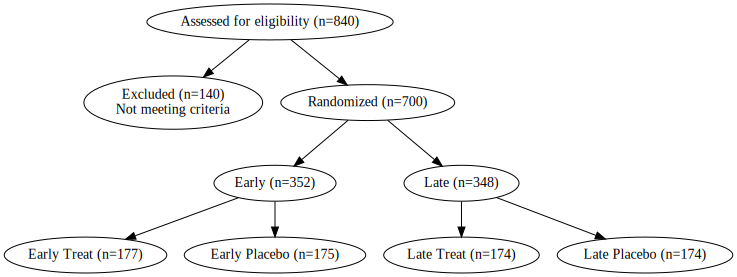

In [12]:
from graphviz import Digraph

dot = Digraph(comment='CONSORT Diagram')

#First nodes
dot.node('A', 'Assessed for eligibility (n=840)')
dot.node('B', 'Excluded (n=140)\nNot meeting criteria')
dot.node('C', 'Randomized (n=700)')

# Nodes Early vs Late
dot.node('D', 'Early (n=352)')
dot.node('E', 'Late (n=348)')

# Subgroups
dot.node('F', 'Early Treat (n=177)')
dot.node('G', 'Early Placebo (n=175)')
dot.node('H', 'Late Treat (n=174)')
dot.node('I', 'Late Placebo (n=174)')

# Conections
dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('C', 'D')
dot.edge('C', 'E')
dot.edge('D', 'F')
dot.edge('D', 'G')
dot.edge('E', 'H')
dot.edge('E', 'I')

dot #PLOT

# 3. Exploratory Data Analysis (EDA)

Lets explore our dataset:

In [13]:
df.describe()

,Age,Inflammatory markers pre,Week 8 outcome,Time to recovery,Time to death,Week 8 clinical score,Inflammatory markers post
count,700.000000,700.000000,700.000000,246.000000,700.000000,246.000000,246.000000
mean,40.521429,9.975562,0.351429,19.547807,31.510264,1.995935,4.367874
std,11.897432,2.956830,0.477758,5.790609,20.065255,1.169329,2.194718
min,20.000000,0.276198,0.000000,6.874287,1.000000,0.000000,0.000000
25%,30.000000,7.916159,0.000000,15.343043,14.724882,1.000000,2.713491
50%,42.000000,9.995711,0.000000,19.365427,26.708642,2.000000,4.011333
75%,51.000000,11.899198,1.000000,23.367519,56.000000,3.000000,5.636248
max,60.000000,21.558194,1.000000,36.263657,57.201692,4.000000,10.922607


Our simulated dataset includes 700 patients, of whom 246 survived. The "NA" entries in the last three columns correspond to non-survivors. On average, patients are around 40 years old, and recovery among survivors takes roughly 19 days.

Now, let’s explore how the data behaves across the different groups (treatments):

In [14]:
# Agrupar por tratamiento y calcular media y std

conti_vars = ['Age', 'Inflammatory markers pre', 'Time to recovery', 'Time to death', 'Inflammatory markers post']

grouped_summary = df.groupby('Treatment group')[conti_vars].agg(['mean','std'])
grouped_summary

Age            Inflammatory markers pre            \
                      mean        std                     mean       std   
Treatment group                                                            
EarlyP           40.240000  11.978410                 9.994752  3.123483   
EarlyT           40.689266  11.925410                 9.852138  3.120642   
LateP            40.614943  11.616015                10.026528  2.822513   
LateT            40.540230  12.160587                10.030848  2.759908   

                Time to recovery           Time to death             \
                            mean       std          mean        std   
Treatment group                                                       
EarlyP                 22.033828  4.798300     31.988059  18.904820   
EarlyT                 16.927914  4.877763     48.064800  13.352441   
LateP                  19.611878  5.156435     29.091539  17.131567   
LateT                  27.789646  3.302322     16.608489  16.809819   

                Inflammatory markers post            
                                     mean       std  
Treatment group                                      
EarlyP                           5.572151  2.381808  
EarlyT                           3.407825  1.465105  
LateP                            5.068835  2.334943  
LateT                            5.227402  2.513330

As expected, the mean age is very similar across treatment groups, with a standard deviation of about 12 years. The time to recovery appears to be shorter in the Early Treatment group and longer in the Late Treatment group — in fact, even longer than in the Placebo groups.

In addition, the mean level of inflammatory markers after treatment is lower in the Early Treatment group, suggesting a potential beneficial effect of earlier intervention.

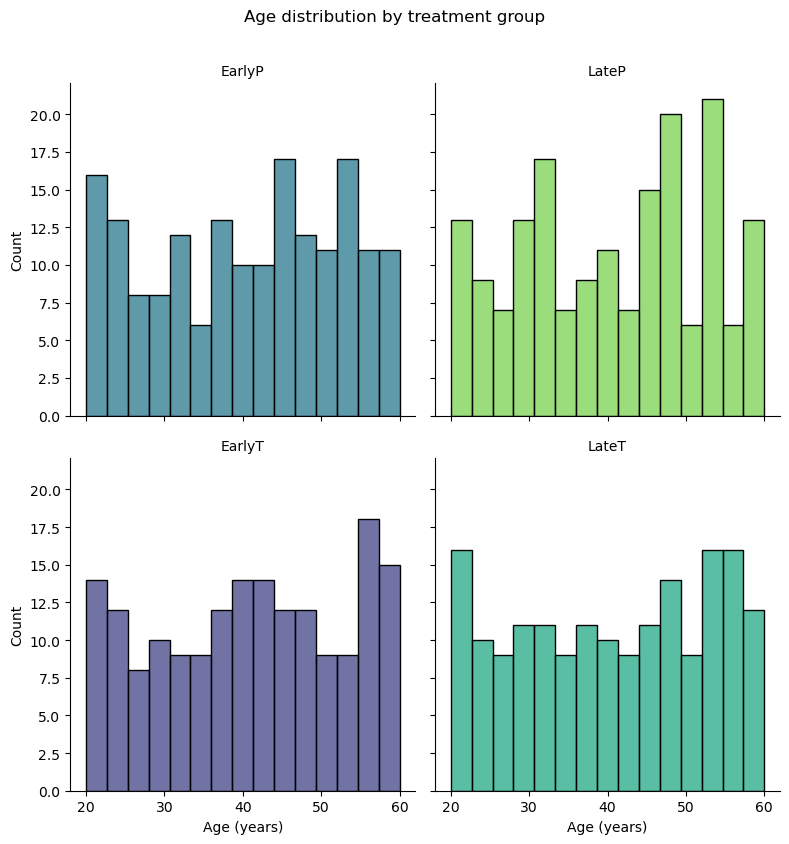

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom palette
custom_palette = {
    "EarlyT": "#1f77b4",   # strong blue
    "EarlyP": "#aec7e8",   # light blue
    "LateT":  "#2ca02c",   # strong green
    "LateP":  "#98df8a"    # light green
}

# Sample 4 colors from Viridis
viridis_palette = sns.color_palette("viridis", 4)

# Assign to your groups
custom_palette1 = {
    "EarlyT": viridis_palette[0],  # darkest
    "EarlyP": viridis_palette[1],
    "LateT":  viridis_palette[2],
    "LateP":  viridis_palette[3],  # lightest
}

# Order in the plot (placebo first row, treatment second row)
order = ["EarlyP", "LateP", "EarlyT", "LateT"]

g = sns.FacetGrid(
    df, 
    col="Treatment group", 
    col_wrap=2, 
    height=4, 
    sharex=True, 
    sharey=True, 
    hue="Treatment group", 
    palette=custom_palette1,
    col_order=order
)

# Map histogram with colors
g.map_dataframe(sns.histplot, x="Age", bins=15, edgecolor="black")

g.set_axis_labels("Age (years)", "Count")
g.set_titles("{col_name}")
plt.suptitle("Age distribution by treatment group", y=1.05)

plt.show()

The upper plot shows the age distribution across the different treatment groups (*blue: EarlyT darkblue: EarlyP; green: LateT and dark green: LateP*). Overall, the distributions are similar. In the LateP group, certain ages appear more frequently than others; however, these peaks are spread across the entire age range and therefore are unlikely to have a major impact on our results.

In [16]:
import pandas as pd


#
df_long = df.melt(
    id_vars=['Treatment group'], 
    value_vars=['Inflammatory markers pre', 'Inflammatory markers post'], 
    var_name='Time', 
    value_name='Markers'  # <-- nombre único
)

In [17]:
df_long.head()

,Treatment group,Time,Markers
0,EarlyT,Inflammatory markers pre,11.490142
1,LateP,Inflammatory markers pre,9.585207
2,EarlyP,Inflammatory markers pre,11.943066
3,LateT,Inflammatory markers pre,14.569090
4,EarlyP,Inflammatory markers pre,9.297540


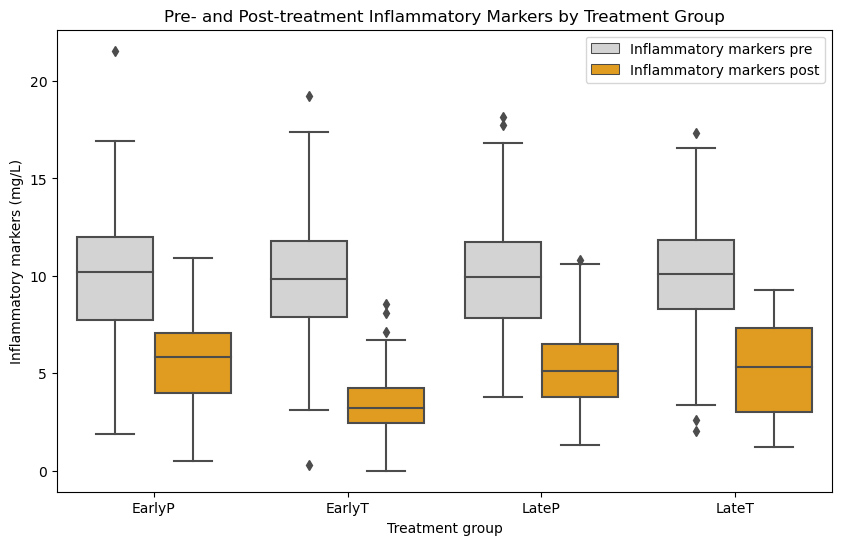

In [18]:
plt.figure(figsize=(10,6))

order = ["EarlyP", "EarlyT","LateP", "LateT"]

sns.boxplot(
    data=df_long,
    x='Treatment group',
    y='Markers',
    order=order,
    hue='Time',
    palette=['lightgray', 'orange']  # pre = lightgray, post = orange (puedes cambiar)
)

plt.title("Pre- and Post-treatment Inflammatory Markers by Treatment Group")
plt.ylabel("Inflammatory markers (mg/L)")
plt.xlabel("Treatment group")
plt.legend()
plt.show()

As expected, inflammatory markers are higher at the onset of the illness (before treatment) than 8 weeks later. Interestingly, patients in the Early Treatment group appear to recover more effectively, showing lower inflammatory marker values at the eight-week follow-up.

In [19]:
# Counts of each outcome per treatment group
survival_counts = df.groupby('Treatment group')['Week 8 outcome'].value_counts().unstack()

# Rename columns
survival_counts.columns = ['Death', 'Survived']

# Show table
survival_counts

,Death,Survived
Treatment group,,
EarlyP,115,60
EarlyT,53,124
LateP,133,41
LateT,153,21


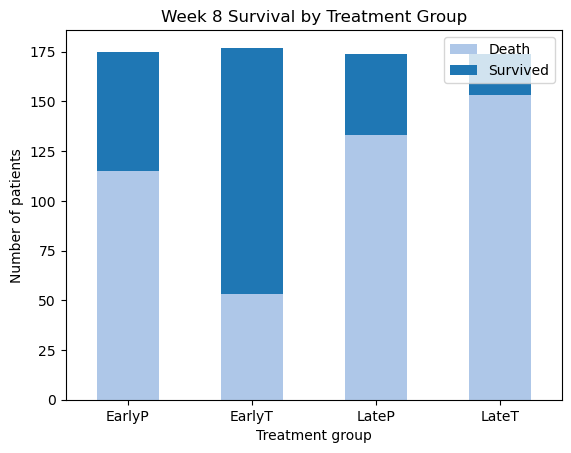

In [20]:
import matplotlib.pyplot as plt

survival_palette = {
    "Death": "#aec7e8",    # light blue
    "Survived": "#1f77b4", # strong blue
}

# Plot stacked bar
survival_counts.plot(kind='bar', stacked=True, color=[survival_palette[col] for col in survival_counts.columns])

plt.ylabel("Number of patients")
plt.title("Week 8 Survival by Treatment Group")
plt.xticks(rotation=0)
plt.show()

**Early Treatment clearly improves the primary outcome**, with a substantially higher survival rate compared to the placebo group. Interestingly, **Late Treatment does not seem to provide a survival benefit** — and may even be associated with a slight decrease in survival.

In addition, the Early Placebo group also shows a higher survival rate than the Late Placebo group. This difference could be explained by unmeasured factors in the study — for instance, increased medical attention during the early phase, or simply a stronger placebo effect before symptoms become more severe.

In [21]:
#Treatment + Sex vs Outcome
sex_survival = pd.crosstab(
    [df['Treatment group'], df['Sex']],
    df['Week 8 outcome']
)

# Rename 
sex_survival.columns = ['Death', 'Survived']

# Calculate total and percentages
sex_survival['Total'] = sex_survival['Death'] + sex_survival['Survived']
sex_survival['Death %'] = sex_survival['Death'] / sex_survival['Total'] * 100
sex_survival['Survived %'] = sex_survival['Survived'] / sex_survival['Total'] * 100

sex_survival[['Death %','Survived %']]

Death %  Survived %
Treatment group Sex                          
EarlyP          Female  70.238095   29.761905
                Male    61.538462   38.461538
EarlyT          Female  25.581395   74.418605
                Male    34.065934   65.934066
LateP           Female  76.190476   23.809524
                Male    76.666667   23.333333
LateT           Female  90.476190    9.523810
                Male    85.555556   14.444444

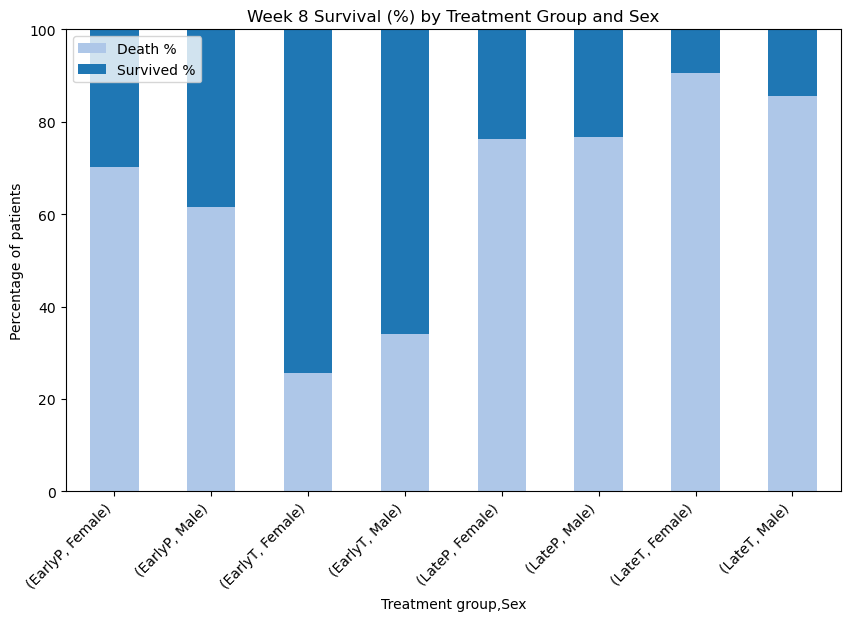

In [22]:
# Pivot
plot_df = sex_survival[['Death %','Survived %']].reset_index()
plot_df.set_index(['Treatment group','Sex'], inplace=True)

# Plot
plot_df.plot(kind='bar', stacked=True, color=['#aec7e8','#1f77b4'], figsize=(10,6))

plt.ylabel("Percentage of patients")
plt.title("Week 8 Survival (%) by Treatment Group and Sex")
plt.xticks(rotation=45, ha='right')
plt.ylim(0,100)
plt.show()

There is some variance across the data. Although no strong differences are observed, slight variations between sexes in the Early Treatment and Placebo groups could suggest potential sex-related differences in treatment response, although they may also simply reflect random noise.

In [23]:
# Crosstab: Treatment group vs Clinical score
score_counts = pd.crosstab(df['Treatment group'], df['Week 8 clinical score'])

# Optional: reorder rows
score_counts = score_counts.reindex(order)
score_counts


Week 8 clinical score,0.0,1.0,2.0,3.0,4.0
Treatment group,,,,,
EarlyP,10,11,12,17,10
EarlyT,0,46,58,6,14
LateP,6,10,7,6,12
LateT,3,5,8,2,3


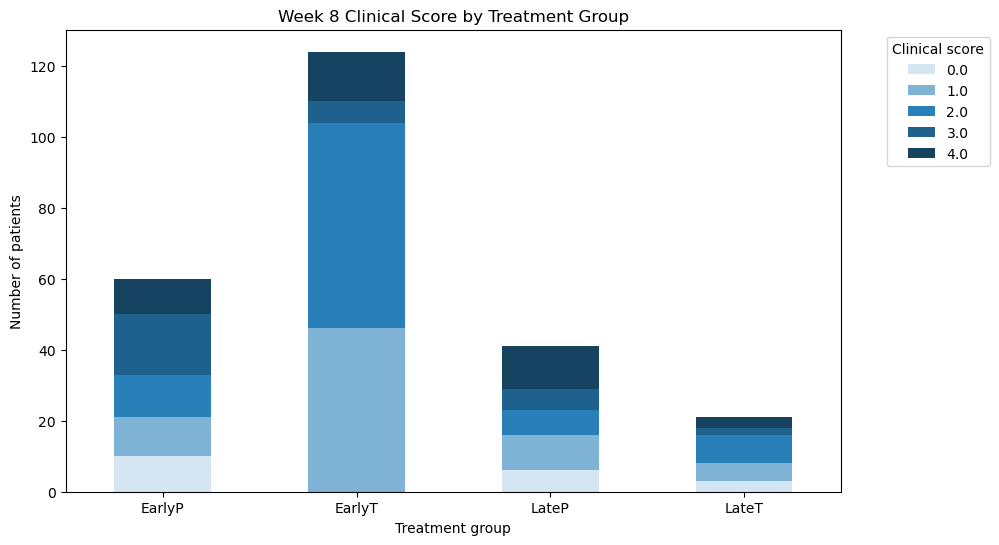

In [24]:
# Define colors for clinical scores 0–4
score_colors = ['#d4e6f1','#7fb3d5','#2980b9','#1f618d','#154360']  # light to dark blue

order = ["EarlyP",  "EarlyT", "LateP","LateT"]

# Reindex the DataFrame to match desired order
score_counts_ordered = score_counts.reindex(order)

# Plot
score_counts_ordered.plot(
    kind='bar',
    stacked=True,
    color=score_colors,
    figsize=(10,6)
)

plt.ylabel("Number of patients")
plt.title("Week 8 Clinical Score by Treatment Group")
plt.xticks(rotation=0)
plt.legend(title="Clinical score", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Finally, we examined how the week 8 clinical score was distributed across categories. The differences in the total number of patients also reflect the survival rates of each group, which explains why the Early Treatment group includes more patients overall.

The **Early Treatment group also shows a higher proportion of patients with low clinical scores (1–2)**, potentially indicating better recovery compared to the other groups. Interestingly, **in this group we did not observe any patient with a score of 0 (better than baseline)** — suggesting that, regardless of treatment or timing, patients still needed to go through the full course of the infection to achieve these unexpected benefits, which may not have occurred in the Early Treatment group.

# 4. Treatment Efficacy and Outcome Analysis

Following the exploratory analyses, we will test two independent hypotheses:

- **Early Treatment significantly increases patient survival probability.**
- **Late Treatment is contraindicated and should not be applied, as it may adversely affect patient outcomes.**

### Kaplan-Meier plot and Log-rank test

We will start by producing a **Kaplan–Meier (KM) plot**. The KM method is used to estimate the survival probability over time, showing the fraction of patients who remain alive at each time point after treatment or placebo. The KM curves allow us to visually compare survival between treatment groups

In our analysis, patients who survive through Week 8 are treated as **censored** at their last observed time. This means their survival time is included in the analysis up to the point we last observed them, but no event (death) occurred.

In [68]:
#pip install lifelines==0.27.4 #this version works with my pandas version

In [25]:
from lifelines import KaplanMeierFitter

{'EarlyP': 26.34, 'EarlyT': 57.2, 'LateP': 24.74, 'LateT': 12.32}


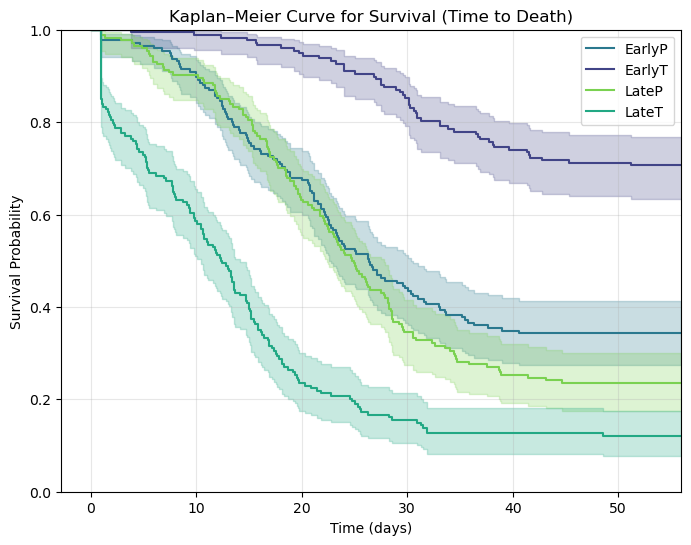

In [26]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
plt.rcParams["figure.autolayout"] = True

median_times = {}

for group in order:
    kmf = KaplanMeierFitter()
    mask = df['Treatment group'] == group
    T = df.loc[mask, 'Time to death']
    E = 1 - df.loc[mask, 'Week 8 outcome']
    kmf.fit(T, event_observed=E, label=group)
    ax = kmf.plot_survival_function(ci_show=True, color=custom_palette1[group])
    ax.set_xlim(right=T.max())
    median_times[group] = round(kmf.median_survival_time_, 2)

print(median_times)
plt.title("Kaplan–Meier Curve for Survival (Time to Death)")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.show()

The plot and median survival times suggest differences across treatment groups. Before drawing any conclusions, we will formally test the statistical significance of these differences using a **log-rank test**, which evaluates whether the survival curves differ significantly.

We will perform two separate tests (EarlyT vs EarlyP and LateT vs LateP) involving completely independent sets of patients. Therefore, no multiple comparison correction will be applied. 

In [27]:
from lifelines.statistics import logrank_test

result_long = logrank_test(
    df[df['Treatment group'] == 'EarlyT']['Time to death'],
    df[df['Treatment group'] == 'EarlyP']['Time to death'],
    event_observed_A=1 - df[df['Treatment group'] == 'EarlyT']['Week 8 outcome'],
    event_observed_B=1 - df[df['Treatment group'] == 'EarlyP']['Week 8 outcome']
)
print(result_long.summary)

   test_statistic             p  -log2(p)
0       62.459586  2.719688e-15  48.38548


In [28]:
result_long1 = logrank_test(
    df[df['Treatment group'] == 'LateT']['Time to death'],
    df[df['Treatment group'] == 'LateP']['Time to death'],
    event_observed_A=1 - df[df['Treatment group'] == 'LateT']['Week 8 outcome'],
    event_observed_B=1 - df[df['Treatment group'] == 'LateP']['Week 8 outcome']
)
print(result_long1.summary)

   test_statistic             p   -log2(p)
0       41.958223  9.324445e-11  33.320191


We detected significant differences (p.value < 0.05) in both cases. Together with the plot and the median values we can determine:

- **EarlyT** increases the survival probability over time when compared to the EarlyP
- On the other hand, **LateT** decreases the survival probability when compared to the LateP, highlighting a potential effect of delayed treatment timing.

For completeness, we also compared the two placebo groups (EarlyP vs LateP). As expected, no significant difference was observed (p.value > 0.05):

In [29]:
result_long2 = logrank_test(
    df[df['Treatment group'] == 'EarlyP']['Time to death'],
    df[df['Treatment group'] == 'LateP']['Time to death'],
    event_observed_A=1 - df[df['Treatment group'] == 'EarlyP']['Week 8 outcome'],
    event_observed_B=1 - df[df['Treatment group'] == 'LateP']['Week 8 outcome']
)
print(result_long2.summary)

   test_statistic         p  -log2(p)
0        2.839451  0.091976  3.442605


### Differences across groups for continuous variables – Shapiro, ANOVA, and Post-hoc Test (Tukey)

We next examine **whether the different treatment groups differ in time to recovery (secondary outcome)**. 

Prior to applying **Analysis of Variance (ANOVA)**, it is necessary to verify that the data are approximately normally distributed within each group. If the normality assumption is violated, a non-parametric test should be employed. **Normality will be assessed using the Shapiro-Wilk test**.

In [30]:
from scipy.stats import shapiro, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [31]:
#Check normality for each group

# Check normality for each group
groups = df['Treatment group'].unique()

for group in groups:
    data = df.loc[df['Treatment group'] == group, 'Time to recovery'].dropna()  # drop NaNs
    if len(data) < 3:
        print(f"{group}: Not enough data for Shapiro-Wilk test (n={len(data)})")
        continue
    stat, p = shapiro(data)
    print(f"{group}: Shapiro-Wilk stat={stat:.3f}, p={p:.3f}")
    if p > 0.05:
        print(f"  → {group} Normally distributed")
    else:
        print(f"  → {group} NOT normally distributed")

EarlyT: Shapiro-Wilk stat=0.976, p=0.024
  → EarlyT NOT normally distributed
LateP: Shapiro-Wilk stat=0.955, p=0.106
  → LateP Normally distributed
EarlyP: Shapiro-Wilk stat=0.990, p=0.910
  → EarlyP Normally distributed
LateT: Shapiro-Wilk stat=0.964, p=0.603
  → LateT Normally distributed


One group (EarlyT) deviated from normality according to the Shapiro–Wilk test. However, ANOVA is generally robust to mild violations of normality, particularly when group sizes are similar. For this analysis, I will therefore proceed with **ANOVA**. In applied research, alternative approaches such as data transformation or the Kruskal–Wallis test could also be considered.

ANOVA is a statistical method used to compare the means of two or more groups by analyzing the variance within and between groups. If the ANOVA p-value is significant (p < 0.05), a **post-hoc test, such as TukeyHSD**, can be performed to identify which specific groups differ. Tukey HSD provides adjusted p-values that account for multiple comparisons, so no additional correction is required.

In [32]:
# ANOVA
data_groups = [df.loc[df['Treatment group'] == group, 'Time to recovery'].dropna() for group in groups]

f_stat, p_value = f_oneway(*data_groups)
print(f"ANOVA F-statistic={f_stat:.3f}, p-value={p_value:.3e}")

if p_value < 0.05:
    tukey = pairwise_tukeyhsd(endog=df['Time to recovery'].dropna(),
                              groups=df.loc[df['Time to recovery'].notna(), 'Treatment group'],
                              alpha=0.05)
    print(tukey.summary())

ANOVA F-statistic=38.382, p-value=2.515e-20
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
EarlyP EarlyT  -5.1059    0.0 -7.0571 -3.1547   True
EarlyP  LateP  -2.4219 0.0636  -4.936  0.0921  False
EarlyP  LateT   5.7558    0.0    2.61  8.9016   True
EarlyT  LateP    2.684 0.0113  0.4488  4.9192   True
EarlyT  LateT  10.8617    0.0  7.9339 13.7895   True
 LateP  LateT   8.1778    0.0  4.8483 11.5072   True
----------------------------------------------------


As expected, no significant differences were observed between the two placebo groups. In addition:

- EarlyT vs EarlyP showed significant differences, with the EarlyT mean being lower, indicating that patients who received the treatment early recovered faster.

- LateT vs LateP also showed significant differences; in this case, the LateT mean was higher, suggesting that patients who received the treatment later recovered more slowly.

### Differences across groups for survival – Chi-square test

We next examine **whether the different treatment groups differ in survival outcome (primary outcome)**. 

To perform this analysis, we first construct a contingency table of survival counts by treatment group and then apply a **Chi-square test**. If the test is significant, post-hoc pairwise comparisons are performed with a Bonferroni correction to identify which groups differ while controlling for multiple comparisons.

In [33]:
import itertools
from scipy.stats import chi2_contingency, fisher_exact

groups = df['Treatment group'].unique()
comparisons = list(itertools.combinations(groups, 2))

print("Pairwise comparisons (with Bonferroni correction):")
alpha = 0.05
bonferroni_alpha = alpha / len(comparisons)

for g1, g2 in comparisons:
    table = pd.crosstab(df[df['Treatment group'].isin([g1,g2])]['Treatment group'],
                        df[df['Treatment group'].isin([g1,g2])]['Week 8 outcome'])
    chi2, p, _, _ = chi2_contingency(table)
    #print(table)
    significance = "significant" if p < bonferroni_alpha else "not significant"
    print(f"{g1} vs {g2}: p={p:.3e} → {significance}")


Pairwise comparisons (with Bonferroni correction):
EarlyT vs LateP: p=6.761e-18 → significant
EarlyT vs EarlyP: p=3.809e-11 → significant
EarlyT vs LateT: p=8.947e-28 → significant
LateP vs EarlyP: p=3.657e-02 → not significant
LateP vs LateT: p=7.774e-03 → significant
EarlyP vs LateT: p=1.678e-06 → significant


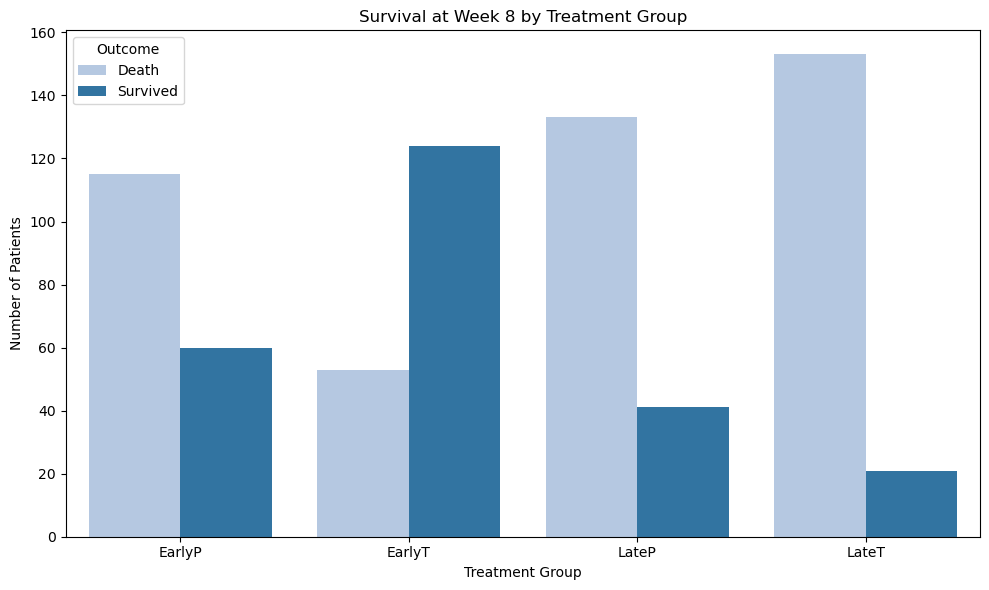

In [34]:
order = ["EarlyP",  "EarlyT","LateP", "LateT"]

plt.figure(figsize=(10,6))
sns.countplot(
    x='Treatment group',
    hue='Week 8 outcome',
    order=order,
    data=df,
    palette=['#aec7e8', '#1f77b4']  # maps hue levels to colors
)
plt.title("Survival at Week 8 by Treatment Group")
plt.xlabel("Treatment Group")
plt.ylabel("Number of Patients")
plt.legend(title="Outcome", labels=["Death", "Survived"])
plt.show()

As expected, no significant differences were observed between the placebo groups. However, significant differences were detected in the other pairwise comparisons, and these remained significant after applying a Bonferroni correction for multiple testing.

# 5. Conclusions

In this analysis of a simulated clinical trial, we performed reproducible statistical analyses to evaluate the efficacy of the treatment. Based on the results, we conclude the following:

- **Early treatment is significantly effective against the ALIEN-1 virus.** Patients receiving early treatment show reduced mortality (Chi-square test), increased survival probability (Kaplan–Meier/log-rank), and shorter recovery times (ANOVA/Tukey). Preliminary data also suggest milder symptoms at Week 8 compared to untreated patients.

- **Late treatment is not recommended.** Patients treated later exhibit higher mortality, decreased survival probability, and longer recovery times, indicating that delayed administration may be detrimental.

- Some unexpected benefits may occur when a patient progresses through the full infection process without early intervention. Further studies would be needed to clarify these effects.

These findings address the primary and selected secondary endpoints of the study, demonstrating the timing-dependent efficacy of the treatment. While this dataset is simulated and illustrative, the analyses show proper application of statistical methods and highlight how early intervention can impact clinical outcomes.